In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.patches import Ellipse

In [98]:
def start_end_line(start, end):
    slope = (start[1] - end[1]) / (start[0] - end[0])
    b = start[1] - (slope * start[0])
    x = np.linspace(start[0], end[0])
    y = slope * x + b
    return (x, y)


def get_midpoint(start, stop):
    delta_x = stop[0] + start[0]
    delta_y = stop[1] + start[1]
    if delta_x == 0:
        midpoint_x = start[0]
    else:
        midpoint_x = delta_x / 2
    if delta_y == 0:
        midpoint_y = start[1]
    else:
        midpoint_y = delta_y / 2
    return (midpoint_x, midpoint_y)


def angle_from_x_axis(start, stop):
    delta_x = start[0] - stop[0]
    delta_y = start[1] - stop[1]
    theta = np.arctan(delta_y / delta_x)
    return theta


def rotate_point(point, center_of_rotation, angle_positive_counterclockwise_radians):
    x_0 = point[0]
    y_0 = point[1]
    
    x_c = center_of_rotation[0]
    y_c = center_of_rotation[1]
    
    theta = angle_positive_counterclockwise_radians
    
    cos = np.cos(theta)
    sin = np.sin(theta)
    
    x_1 = (cos * (x_0 - x_c)) - (sin * (y_0 - y_c)) + x_c
    y_1 = (sin * (x_0 - x_c)) + (cos * (y_0 - y_c)) + y_c
    
    return (x_1, y_1)

def is_in_ellipse(start, stop, max_distance, df):
    
    midpoint = get_midpoint(start = start, stop = stop)
    target_list = list(zip(df['longitude_gas'], df['latitude_gas']))
    
    
    # transform all points so midpoint is centered
    start_translated = (start[0] - midpoint[0], start[1] - midpoint[1])
    stop_translated = (stop[0] - midpoint[0], stop[1] - midpoint[1])
    
    targets_translated = []
    for x in range(len(target_list)):
        target_translated = (target_list[x][0] - midpoint[0], target_list[x][1] - midpoint[1])
        targets_translated.append(target_translated)
    
    
    theta = angle_from_x_axis(start = start, stop = stop)
    theta_degrees = theta * 180 / np.pi
    start_rotated = rotate_point(point = start_translated, center_of_rotation = (0, 0), angle_positive_counterclockwise_radians = -theta)
    stop_rotated = rotate_point(point = stop_translated, center_of_rotation = (0, 0), angle_positive_counterclockwise_radians = -theta)
    
    target_list_rotated = []
    for x in range(len(targets_translated)):
        target_point = targets_translated[x]
        target_point_rotated = rotate_point(point = target_point, center_of_rotation = (0, 0), angle_positive_counterclockwise_radians = -theta)
        target_list_rotated.append(target_point_rotated)
    
    # define the major an minor axis
    delta_x_rotated = stop_rotated[0] - start_rotated[0]
    delta_y_rotated = stop_rotated[1] - start_rotated[1] # should always be zero
    
    major_axis = delta_x_rotated * max_distance # a + b
    minor_axis = major_axis * np.sqrt(max_distance**2 - 1) # formula below
    
    # see which points are in ellipse
    in_ellipse = []
    for x in range(len(target_list_rotated)):
        x_target = target_list_rotated[x][0]
        y_target = target_list_rotated[x][1]
        
        component1 = (x_target / (major_axis/2))**2
        component2 = (y_target / (minor_axis/2))**2
        
        if component1 + component2 <= 1:
            in_ellipse.append('1')
        else:
            in_ellipse.append('0')
        #in_ellipse.append(str(component1 + component2))
        #in_ellipse.append((x_target, y_target))
    
    mapped = [int(x) for x in in_ellipse]
    
    df['in_ellipse'] = mapped
    
    return df, start, stop, major_axis, minor_axis, theta_degrees
    #return theta_degrees

In [99]:
def show_amenity_ellipse(result_from_isinellipse_function):
    result = result_from_isinellipse_function
    df = result[0]
    start = result[1]
    stop = result[2]
    major_axis = result[3]
    minor_axis = result[4]
    theta_degrees = result[5]
    
    df_zeros = df.loc[df['in_ellipse'] == 0]
    df_ones = df.loc[df['in_ellipse'] == 1]
    
    plt.figure(figsize=(12, 12))
    ellipse = Ellipse(xy = get_midpoint(start, stop), width = major_axis, height = minor_axis, angle = theta_degrees, alpha = .4)
    plt.gca().add_patch(ellipse)
    plt.scatter(df_zeros['longitude_gas'], df_zeros['latitude_gas'], marker = 'o', c = df_zeros['rating'])
    plt.scatter(df_ones['longitude_gas'], df_ones['latitude_gas'], marker = "^", c = df_ones['rating'])
    plt.show()
    #plt.savefig('test_graph.png')

In [128]:
def get_ellipse_image(result_from_isinellipse_function, img_name):
    result = result_from_isinellipse_function
    df = result[0]
    start = result[1]
    stop = result[2]
    major_axis = result[3]
    minor_axis = result[4]
    theta_degrees = result[5]
    
    #df_zeros = df.loc[df['in_ellipse'] == 0]
    #df_ones = df.loc[df['in_ellipse'] == 1]
    
    #graph_xmin = df['longitude_gas'].min()
    #graph_xmax = df['longitude_gas'].max()
    #graph_ymin = df['latitude_gas'].min()
    #graph_ymax = df['latitude_gas'].max()
    
    #[[32.5504761, -124.28758], [41.9643067, -114.5703842]]
    
    graph_xmin = -124.28758
    graph_xmax = -114.5703842
    graph_ymin = 32.5504761
    graph_ymax = 41.9643067
    
    #fig, ax = plt.subplots()
    #plt.figure(figsize=(12, 12))
    #ax.axis("off")
    ellipse = Ellipse(xy = get_midpoint(start, stop), width = major_axis, height = minor_axis, angle = theta_degrees, alpha = .4)
    plt.gca().add_patch(ellipse)
    #plt.axis('scaled')
    plt.xlim(graph_xmin, graph_xmax)
    plt.ylim(graph_ymin, graph_ymax)
    plt.axis("off")
    
    plt.savefig('./folium_ranges/'+img_name+'.png')
    #return ((graph_xmin, graph_ymin), (graph_xmax, graph_ymax))

In [78]:
gas_df = pd.read_csv('./data/from_shiff')
gas_df = gas_df.loc[gas_df['x'] != gas_df['x'].max()]
gas_df = gas_df[['name', 'x', 'y', '0']]
gas_df.rename(columns = {'0': 'rating'}, inplace = True)

In [132]:
golden_gate_coords = (-122.4783, 37.8199)
tahoe_coords = (-120.0324, 39.0968)
la_coords = (-118.2437, 34.0522)

mappings = is_in_ellipse(start = la_coords, stop = tahoe_coords, max_distance = 1.1, df = gas_df)
show_amenity_ellipse(result_from_isinellipse_function = mappings)
#get_ellipse_image(result_from_isinellipse_function = mappings)
#mappings[0]

# ((graph_xmin, graph_ymin), (graph_xmax, graph_ymax))
# ((-124.28758, 32.5504761), (-114.5703842, 41.9643067))

KeyError: 'longitude_gas'

# Folium test

In [85]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
from folium.raster_layers import ImageOverlay
#from scipy.ndimage import imread
import cv2 

In [71]:
cal_coordinates = (36.7783, -119.4179)
data = pd.read_csv('./data/master_df_take3.csv')

In [72]:
#fire
fire_data = data[['longitude_fire', 'latitude_fire', 'radius_meters_fire', 'status_fire']]
fire_data.dropna(inplace = True)
fire_data_contained = fire_data.loc[fire_data['status_fire'] == 'contained']
fire_data_ongoing = fire_data.loc[fire_data['status_fire'] == 'ongoing']

#covid
covid_data = data[['longitude_covid', 'latitude_covid', 'cases_covid']]
covid_data.dropna(inplace = True)

#gas
gas_data = data[['gas_name', 'longitude_gas', 'latitude_gas', 'risk_level_gas']]
gas_data.dropna(inplace = True)
gas_data_veryhighrisk = gas_data.loc[gas_data['risk_level_gas'] == 'Very High Risk']
gas_data_highrisk = gas_data.loc[gas_data['risk_level_gas'] == 'High Risk']
gas_data_mediumrisk = gas_data.loc[gas_data['risk_level_gas'] == 'Medium Risk']
gas_data_lowrisk = gas_data.loc[gas_data['risk_level_gas'] == 'Low Risk']

<ipython-input-72-686b29e004b0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fire_data.dropna(inplace = True)
<ipython-input-72-686b29e004b0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_data.dropna(inplace = True)
<ipython-input-72-686b29e004b0>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gas_data.dropna(inplace = True)


In [129]:
folium_map = folium.Map(location=cal_coordinates, zoom_start=10, tiles='CartoDB Positron')
for row in fire_data_contained.iterrows():
    row_values = row[1]
    location = [row_values['latitude_fire'], row_values['longitude_fire']]
    popup = popup ='<strong>' + 'Fire Status:' + str(row_values['status_fire']) + '</strong>'
    marker = folium.Circle(location=location,color = 'orange', radius=row_values['radius_meters_fire'], popup=popup, tooltip='Click here to see more information')
    marker.add_to(folium_map)
    
for row in fire_data_ongoing.iterrows():
    row_values = row[1]
    location = [row_values['latitude_fire'], row_values['longitude_fire']]
    popup = popup ='<strong>' + 'Fire Status:' + str(row_values['status_fire']) + '</strong>'
    marker = folium.Circle(location=location,color = 'red', radius=row_values['radius_meters_fire'], popup=popup, tooltip='Click here to see more information')
    marker.add_to(folium_map)
    
for row in covid_data.iterrows():
    row_values = row[1]
    location = [row_values['latitude_covid'], row_values['longitude_covid']]
    popup = popup ='<strong>' + 'Covid Cases:' + str(row_values['cases_covid']) + '</strong>'
    marker = folium.Circle(location=location,color = 'blue', radius=row_values['cases_covid'], popup=popup, tooltip='Click here to see more information')
    marker.add_to(folium_map)

# gas
for row in gas_data_veryhighrisk.iterrows():
    row_values = row[1]
    location = [row_values['latitude_gas'], row_values['longitude_gas']]
    popup = popup ='<strong>' + 'Gas Station:' + str(row_values['gas_name']) + '</strong>'
    marker = folium.Circle(location=location,color = 'black', radius=1, popup=popup, tooltip='Click here to see more information')
    marker.add_to(folium_map)
    
for row in gas_data_highrisk.iterrows():
    row_values = row[1]
    location = [row_values['latitude_gas'], row_values['longitude_gas']]
    popup = popup ='<strong>' + 'Gas Station:' + str(row_values['gas_name']) + '</strong>'
    marker = folium.Circle(location=location,color = 'purple', radius=1, popup=popup, tooltip='Click here to see more information')
    marker.add_to(folium_map)
    
for row in gas_data_mediumrisk.iterrows():
    row_values = row[1]
    location = [row_values['latitude_gas'], row_values['longitude_gas']]
    popup = popup ='<strong>' + 'Gas Station:' + str(row_values['gas_name']) + '</strong>'
    marker = folium.Circle(location=location,color = 'green', radius=1, popup=popup, tooltip='Click here to see more information')
    marker.add_to(folium_map)
    
for row in gas_data_lowrisk.iterrows():
    row_values = row[1]
    location = [row_values['latitude_gas'], row_values['longitude_gas']]
    popup = popup ='<strong>' + 'Gas Station:' + str(row_values['gas_name']) + '</strong>'
    marker = folium.Circle(location=location,color = 'yellow', radius=1, popup=popup, tooltip='Click here to see more information')
    marker.add_to(folium_map)
    
#img = get_ellipse_image(result_from_isinellipse_function = mappings)
#bounded = [[32.5504761, -124.28758], [41.9643067, -114.5703842]]

# ((graph_xmin, graph_ymin), (graph_xmax, graph_ymax))
# ((-124.28758, 32.5504761), (-114.5703842, 41.9643067))
#img2 = folium.raster_layers.ImageOverlay(image = img, bounds = bounded, opacity = .8).add_to(folium_map)

#folium.LayerControl().add_to(folium_map)

#L.imageOverlay("/test_graph.png",[[32.5504761, -124.28758], [41.9643067, -114.5703842]],).addTo(folium_map);
#https://python-visualization.github.io/folium/modules.html

img = cv2.imread('test_graph.png')
folium_map.add_child(ImageOverlay(img, opacity=0.4, bounds =[[32.5504761, -124.28758], [41.9643067, -114.5703842]]))

display(folium_map)

AttributeError: 'NoneType' object has no attribute 'replace'

In [ ]:
for row in gas_data_lowrisk.iterrows():
    row_values = row[1]
    location = [row_values['latitude_gas'], row_values['longitude_gas']]
    popup = popup ='<strong>' + 'Gas Station:' + str(row_values['gas_name']) + '</strong>'
    marker = folium.Circle(location=location,color = 'yellow', radius=1, popup=popup, tooltip='Click here to see more information')
    marker.add_to(folium_map)

#https://python-visualization.github.io/folium/modules.html

img = cv2.imread('./folium_ranges/test_graph.png')
folium_map.add_child(ImageOverlay(img, opacity=0.4, bounds =[[32.5504761, -124.28758], [41.9643067, -114.5703842]]))

display(folium_map)

In [130]:
def display_folium(start, stop, max_distance, image_notfull_name):
    """
    display the folium map given an image of elliptical boundary for trip
    
    display the safest gas station you should go to
    
    """
    image_name = './folium_ranges/'+image_notfull_name+'.png'
    
    # get dataframe of all gas stations
    gas_df = gas_data
    info_from_ellipse = is_in_ellipse(start = start, stop = stop, max_distance = max_distance, df = gas_df)
    
    #crete the image based on data in ellipse
    #get_ellipse_image(result_from_isinellipse_function = info_from_ellipse, img_name = image_name)
    
    # this dataframe tells you if the gas station is in range or not
    ellipse_df = info_from_ellipse[0]
    in_range = ellipse_df.loc[ellipse_df['in_ellipse'] == 1]
    #break these gas stations into categories
    #lowrisk_gas_station_df = in_range.loc[in_range['rating'] == 1]
    #mildrisk_gas_station_df = in_range.loc[in_range['rating'] == 2]
    #mediumrisk_gas_station_df = in_range.loc[in_range['rating'] == 3]
    #highrisk_gas_station_df = in_range.loc[in_range['rating'] == 4]
    
    gas_data_veryhighrisk = in_range.loc[in_range['risk_level_gas'] == 'Very High Risk']
    gas_data_highrisk = in_range.loc[in_range['risk_level_gas'] == 'High Risk']
    gas_data_mediumrisk = in_range.loc[in_range['risk_level_gas'] == 'Medium Risk']
    gas_data_lowrisk = in_range.loc[in_range['risk_level_gas'] == 'Low Risk']
    
    if gas_data_lowrisk.empty:
        print('please expand your search range')
    else:
        folium_map = folium.Map(location=cal_coordinates, zoom_start=10, tiles='CartoDB Positron')
        for row in fire_data_contained.iterrows():
            row_values = row[1]
            location = [row_values['latitude_fire'], row_values['longitude_fire']]
            popup = popup ='<strong>' + 'Fire Status:' + str(row_values['status_fire']) + '</strong>'
            marker = folium.Circle(location=location,color = 'orange', radius=row_values['radius_meters_fire'], popup=popup, tooltip='Click here to see more information')
            marker.add_to(folium_map)

        for row in fire_data_ongoing.iterrows():
            row_values = row[1]
            location = [row_values['latitude_fire'], row_values['longitude_fire']]
            popup = popup ='<strong>' + 'Fire Status:' + str(row_values['status_fire']) + '</strong>'
            marker = folium.Circle(location=location,color = 'red', radius=row_values['radius_meters_fire'], popup=popup, tooltip='Click here to see more information')
            marker.add_to(folium_map)

        for row in covid_data.iterrows():
            row_values = row[1]
            location = [row_values['latitude_covid'], row_values['longitude_covid']]
            popup = popup ='<strong>' + 'Covid Cases:' + str(row_values['cases_covid']) + '</strong>'
            marker = folium.Circle(location=location,color = 'blue', radius=row_values['cases_covid'], popup=popup, tooltip='Click here to see more information')
            marker.add_to(folium_map)

        # gas
        for row in gas_data_veryhighrisk.iterrows():
            row_values = row[1]
            location = [row_values['latitude_gas'], row_values['longitude_gas']]
            popup = popup ='<strong>' + 'Gas Station:' + str(row_values['gas_name']) + '</strong>'
            marker = folium.Circle(location=location,color = 'black', radius=1, popup=popup, tooltip='Click here to see more information')
            marker.add_to(folium_map)

        for row in gas_data_highrisk.iterrows():
            row_values = row[1]
            location = [row_values['latitude_gas'], row_values['longitude_gas']]
            popup = popup ='<strong>' + 'Gas Station:' + str(row_values['gas_name']) + '</strong>'
            marker = folium.Circle(location=location,color = 'purple', radius=1, popup=popup, tooltip='Click here to see more information')
            marker.add_to(folium_map)

        for row in gas_data_mediumrisk.iterrows():
            row_values = row[1]
            location = [row_values['latitude_gas'], row_values['longitude_gas']]
            popup = popup ='<strong>' + 'Gas Station:' + str(row_values['gas_name']) + '</strong>'
            marker = folium.Circle(location=location,color = 'green', radius=1, popup=popup, tooltip='Click here to see more information')
            marker.add_to(folium_map)

        for row in gas_data_lowrisk.iterrows():
            row_values = row[1]
            location = [row_values['latitude_gas'], row_values['longitude_gas']]
            popup = popup ='<strong>' + 'Gas Station:' + str(row_values['gas_name']) + '</strong>'
            marker = folium.Circle(location=location,color = 'yellow', radius=1, popup=popup, tooltip='Click here to see more information')
            marker.add_to(folium_map)
            
        # gas in range - marker
        for row in gas_data_lowrisk.iterrows():
            row_values = row[1]
            marker = folium.Marker(location = [row_values['latitude_gas'], row_values['longitude_gas']], clustered_marker = True)
            marker.add_to(folium_map)

        #https://python-visualization.github.io/folium/modules.html

        img = cv2.imread(image_name)
        folium_map.add_child(ImageOverlay(img, opacity=0.4, bounds =[[32.5504761, -124.28758], [41.9643067, -114.5703842]]))

        display(folium_map)

start = input("Enter your starting coordinates: ") 
stop = input("Enter your destination coordinates: ") 
max_distance_percent = input("What percentage of driving time are you willing to add on? ") 

max_distance = 1 + (int(max_distance_percent)/100)

display_folium(start, stop, max_distance)

<ipython-input-98-7a70510f91f7>:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['in_ellipse'] = mapped


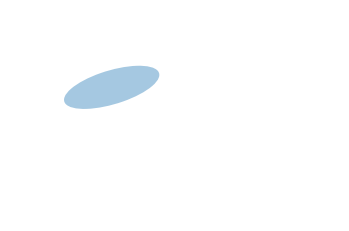

In [131]:
golden_gate_coords = (-122.4783, 37.8199)
tahoe_coords = (-120.0324, 39.0968)
la_coords = (-118.2437, 34.0522)

start = golden_gate_coords 
stop = tahoe_coords
max_distance = 1.1
image_notfull_name = 'test'

info_from_ellipse = is_in_ellipse(start = start, stop = stop, max_distance = max_distance, df = gas_data)
get_ellipse_image(result_from_isinellipse_function = info_from_ellipse, img_name = image_notfull_name)

display_folium(start = golden_gate_coords, stop = tahoe_coords, max_distance = 1.1, image_notfull_name = image_notfull_name)